# Capturing greenhouse gases with data

## Exploratory Data Analysis

### by Zachary Brown

In the ARC-MOF data wrangling notebook I combined five datasets on hypothetical MOF properties and then reduced it to only entries focused on post-combustion vacuum swing adsorption (VSA). Now in this notebook I will explore the data to look for correlations that may help drive model development, and to gain a better understanding for myself as to which features help improve CO2 uptake.

First I'll install any new libraries needed that weren't included in the previous notebook. I'll then import the necessary libraries.

In [7]:
!pip install seaborn==0.12.2
!pip install statsmodels==0.13.5

     ---------------------------------------- 9.1/9.1 MB 25.4 MB/s eta 0:00:00
     ------------------------------------- 233.8/233.8 kB 14.9 MB/s eta 0:00:00
     --------------------------------------- 42.5/42.5 MB 26.2 MB/s eta 0:00:00


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot

In [3]:
data = pd.read_csv('../data/interim/wrangled.csv')

In [4]:
data.head()

,filename,unit_cell_volume,Density,accessible_surface_area,volumetric_surface_area,gravimetric_surface_area,inaccessible_surface_area,inac_grav_surf_area,inac_vol_surf_area,accessible_volume_per_uc,...,D_func-alpha-2-all,D_func-alpha-3-all,order_f-lig,bool_f-lig,order_mc,bool_mc,order_func,bool_func,order_lc,bool_lc
0,DB0-m2_o1_o10_f0_pcu.sym.66.cif,901.788,1.233220,87.4832,970.108,786.644,0.000000,0.000000,0.000000,26.0256,...,41.885780,23.764297,43831,True,18963,True,21096,True,4072,True
1,DB0-m29_o99_o470_f0_pts.sym.128.cif,2552.970,0.754924,419.5890,1643.530,2177.080,0.164038,0.642539,0.851131,268.4700,...,-10.339258,-17.664703,100001,False,100001,False,84717,True,100001,False
2,DB0-m2_o12_o15_f0_pcu.sym.8.cif,1067.230,1.001400,147.2580,1379.820,1377.890,0.000000,0.000000,0.000000,79.2310,...,0.000000,0.000000,100001,False,100001,False,100001,False,100001,False
3,DB0-m29_o96_o110_f0_pts.sym.44.cif,4129.180,0.575417,811.2260,1964.620,3414.250,0.000000,0.000000,0.000000,1303.4200,...,-8.696651,-11.267594,100001,False,100001,False,100001,False,100001,False
4,DB0-m3_o22_o24_f0_nbo.sym.63.cif,4992.800,0.579950,991.2240,1985.310,3423.240,0.000000,0.000000,0.000000,1696.3500,...,0.000000,0.000000,100001,False,100001,False,100001,False,100001,False


In [5]:
print(data.columns.tolist())

['filename', 'unit_cell_volume', 'Density', 'accessible_surface_area', 'volumetric_surface_area', 'gravimetric_surface_area', 'inaccessible_surface_area', 'inac_grav_surf_area', 'inac_vol_surf_area', 'accessible_volume_per_uc', 'volume_fraction', 'grav_volume', 'inac_vol', 'inac_vol_frac', 'inac_grav_vol', 'probe_occupiable_vol', 'probe_occ_vol_frac', 'grav_probe_occ_vol', 'inac_probe_occ_vol', 'inac_probe_occ_vol_frac', 'inac_probe_occ_grav_vol', 'largest_cav_diameter', 'pore_limiting_diameter', 'largest_free_sphere_path_diam', 'order_geo', 'bool_geo', 'Crystalnet', 'likely topology', 'RDF_electronegativity_2.000', 'RDF_electronegativity_2.004', 'RDF_electronegativity_2.013', 'RDF_electronegativity_2.027', 'RDF_electronegativity_2.044', 'RDF_electronegativity_2.066', 'RDF_electronegativity_2.093', 'RDF_electronegativity_2.124', 'RDF_electronegativity_2.159', 'RDF_electronegativity_2.199', 'RDF_electronegativity_2.243', 'RDF_electronegativity_2.292', 'RDF_electronegativity_2.345', 'RDF

I need to select a specific feature as my target for this project. CO2 capture can be measured in many ways: mmol of CO2 adsorbed per gram of material, volume of CO2 adsorbed per volume of material, or the weight of CO2 adsorbed by some mass of material. An important caveat that needs to be considered is that in this process, the material is saturated with CO2, and then it has to be regenerated via a vacuum process. That regeneration may not be 100% perfect, meaning that in a real life process, the 'working capacity' is lower than the absolute measurements. Given these considerations I'll focus on the 'v/v_working_capacity' column as my target, because theoretically we would want smaller filters to catch as much CO2 as possible, rather than focusing on weight. 

With that being said, I'll start out by plotting unit cell volume, density, accessible, volumetric, and gravimetric surface areas, largest cavity diameter, and pore limiting diameter against my target to see if these show any correlation.

In [11]:
data = data.dropna(subset='v/v_working_capacity')
data.shape

(51224, 900)

In [6]:
sns.set_theme('notebook')

In [34]:
from matplotlib import rcParams
rcParams['mathtext.default'] = 'regular'

In [48]:
def correlate(feature, x_label, title):
    adj_data = data.dropna(subset=feature)
    dependent = adj_data[['v/v_working_capacity']]
    independent = sm.add_constant(adj_data[[feature]])
    model = sm.OLS(dependent, independent)
    fit = model.fit()
    b, m = fit.params
    
    x = np.array([0, np.max(adj_data[feature])])
    y = (m*x)+b
    
    sns.scatterplot(data=adj_data, x=feature, y='v/v_working_capacity', alpha=0.1, color='blue')
    plt.plot(x, y, color='red')
    plt.title(title, fontsize = 18)
    plt.xlabel(x_label, fontsize = 14)
    plt.ylabel(r'Volumetric Working $CO_{2}$ Capacity $(cm^{3}/cm^{-3})$', fontsize = 14)
    plt.text(0.75*max(adj_data[feature]), 0.75*max(adj_data['v/v_working_capacity']), 
             'Slope: ' + str(round(fit.params[1], 4)), fontsize = 14)
    plt.savefig('../figures/capacity_vs_'+feature+'.png',dpi=1200, bbox_inches='tight')
    plt.show()

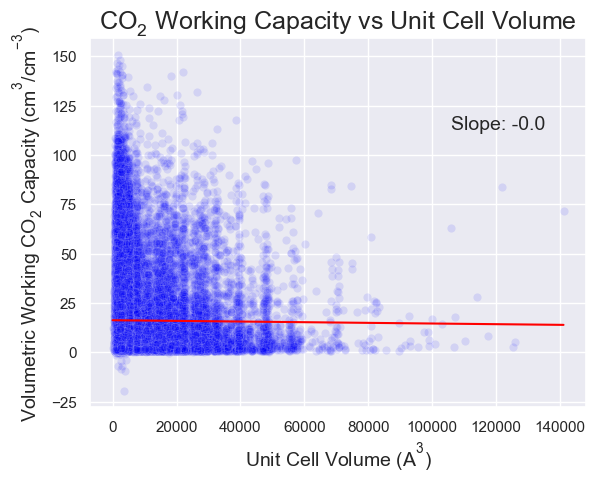

In [49]:
correlate('unit_cell_volume', r'Unit Cell Volume $(A^{3})$', r'$CO_{2}$ Working Capacity vs Unit Cell Volume')

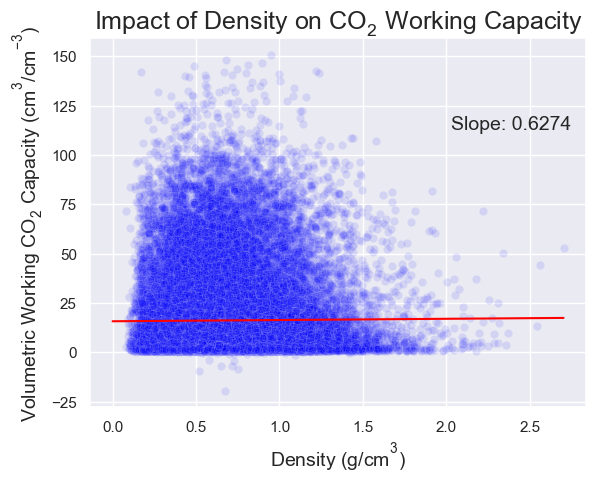

In [61]:
correlate('Density', r'Density $(g/cm^3)$', 'Impact of Density on $CO_2$ Working Capacity')

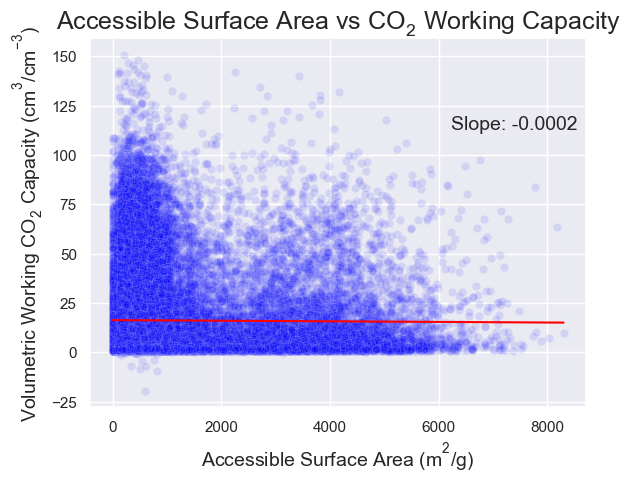

In [53]:
correlate('accessible_surface_area', 'Accessible Surface Area $(m^2/g)$', 'Accessible Surface Area vs $CO_2$ Working Capacity')

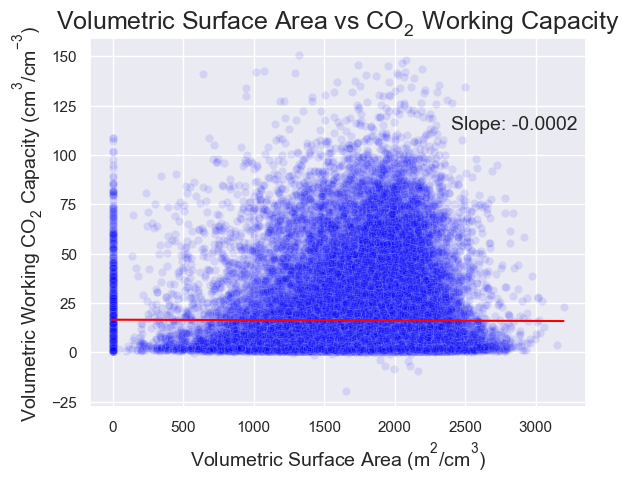

In [59]:
correlate('volumetric_surface_area', 'Volumetric Surface Area $(m^2/cm^3)$', 'Volumetric Surface Area vs $CO_2$ Working Capacity')

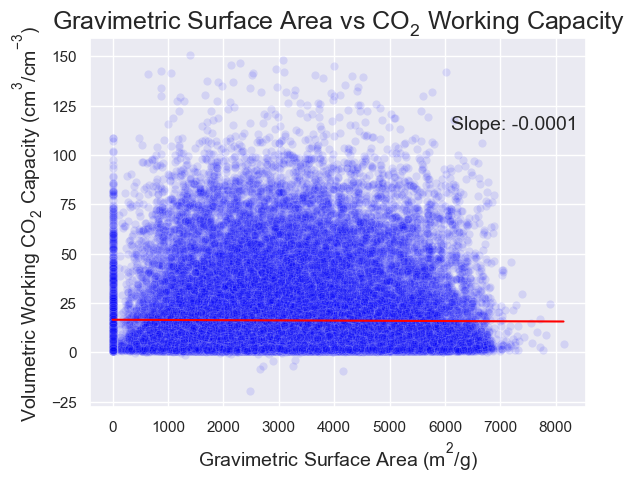

In [60]:
correlate('gravimetric_surface_area', 'Gravimetric Surface Area $(m^2/g)$', 'Gravimetric Surface Area vs $CO_2$ Working Capacity')

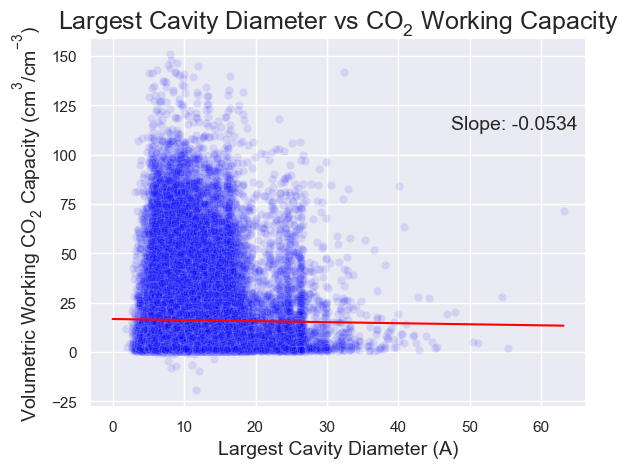

In [58]:
correlate('largest_cav_diameter', 'Largest Cavity Diameter (A)', 'Largest Cavity Diameter vs $CO_2$ Working Capacity')

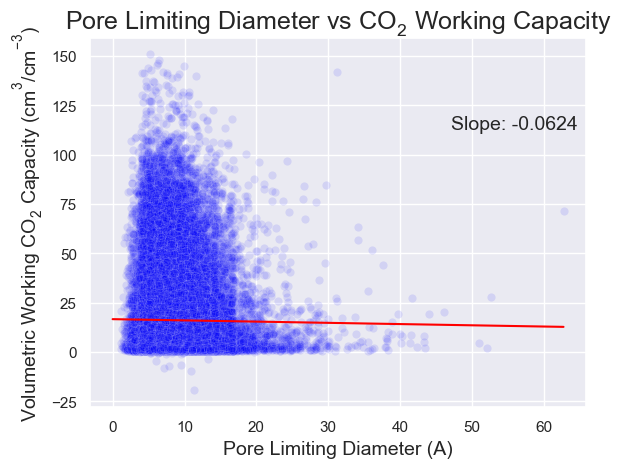

In [57]:
correlate('pore_limiting_diameter', 'Pore Limiting Diameter (A)', 'Pore Limiting Diameter vs $CO_2$ Working Capacity')

Very interesting! So we're seeing some trends already. While surface area has almost no correlation at all with working capacity, the density, pore limiting diameter, and largest cavity diameters are all telling us that smaller pores/openings and a more tightly packed framework is giving us slightly better working capacity. 